<a href="https://colab.research.google.com/github/NV2019/AERO_625_Platooning/blob/main/Affective_Polarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **An Agent-Based Framework for Isolating Causal Pathways for Changes in Affective Polarization**

In [1]:
%reset -f 
import numpy as np
import torch
import random
import time
device = 'cuda'

# Total Agent Population
Group_Size = 1000
Final_Time = 100

# LeftWing Extreme
LW_Extreme = 0.5
# RightWing Extreme
RW_Extreme = 0.5
# Neutral 
Neutral = 0.5

# In-Party Affect
# IPA Extreme
IPA_E_Min = 75
IPA_E_Max = 100
# IPA Moderate
IPA_M_Min = 50
IPA_M_Max = 100

# Out-Party Affect
# OPA Extreme
OPA_E_Min = 0
OPA_E_Max = 25
# OPA Moderate
OPA_M_Min = 25
OPA_M_Max = 50

# Neutral IPA and OPA
N_Min = 0
N_Max = 25

# News Outlets
News_Outlets = 100
NO_Min = 1
NO_Max = 10

# Slant
Slant_Min = 1
Slant_Max = 5

# Total Number of Simulation Runs
Monte_Carlo = 100

News_Index = torch.arange(1,News_Outlets+1,step=1)
# Time Series: 0: Update, 1: News Exposure, 2: In-degree, 3: Out-degree
TimeSeries_Values = torch.zeros((5,Group_Size,Final_Time),dtype=torch.double,device='cuda')
News_Matrix = torch.zeros((Group_Size,News_Outlets),dtype=torch.double,device='cuda')
Difference_Matrix = torch.zeros((Group_Size,News_Outlets),dtype=torch.double,device='cuda')
Gain_Matrix = torch.zeros((Group_Size,News_Outlets),dtype=torch.double,device='cuda')
N_Gain_Matrix = torch.zeros((Group_Size,News_Outlets),dtype=torch.double,device='cuda')
Ones_Matrix = torch.ones((Group_Size,News_Outlets),device='cuda')
NN_Gain_Matrix = torch.zeros((Group_Size,News_Outlets),dtype=torch.double,device='cuda')
PN_Gain_Matrix = torch.zeros((Group_Size,News_Outlets),dtype=torch.double,device='cuda')

Agents = torch.zeros((Group_Size,10),dtype=torch.double,device='cuda')

# Partisan Orientations (Agents[0])
Agents[:,0] = torch.tensor([0,1,2],device='cuda')[torch.multinomial(torch.tensor([0.4,0.4,0.2]),Group_Size,replacement=True)]
# LeftWing Agent Population
LW_Agents = torch.where(Agents[:,0]==0)[0]
# RightWing Agent Population
RW_Agents = torch.where(Agents[:,0]==1)[0]
# Neutral Agent Population
N_Agents = torch.where(Agents[:,0]==2)[0]

# Slant
#LW_Extreme
pick = torch.tensor([True,False])[torch.multinomial(torch.tensor([LW_Extreme,1.0-LW_Extreme]),LW_Agents.size()[0],replacement=True)]
Agents[LW_Agents[pick==True],1] = 1
#LW_Moderates
Agents[LW_Agents[pick==False],1] = 2

#RW_Extreme
pick = torch.tensor([True,False])[torch.multinomial(torch.tensor([RW_Extreme,1.0-RW_Extreme]),RW_Agents.size()[0],replacement=True)]
Agents[RW_Agents[pick==True],1] = 5
#RW_Moderates
Agents[RW_Agents[pick==False],1] = 4

#Neutrals
pick = torch.where(Agents[:,1]==0)[0]
Agents[pick,1] = 3


# LW_Extremes or RW_Extremes
pick = torch.where(torch.logical_or(Agents[:,1]==1,Agents[:,1]==5)==1)[0]
# IPA 75-100
Agents[pick,2] = torch.round(torch.cuda.DoubleTensor(pick.size()[0]).uniform_(IPA_E_Min,IPA_E_Max))
# OPA 0-25
Agents[pick,3] = torch.round(torch.cuda.DoubleTensor(pick.size()[0]).uniform_(OPA_E_Min,OPA_E_Max))

# LW_Moderates or RW_Moderates
pick = torch.where(torch.logical_or(Agents[:,1]==2,Agents[:,1]==4)==1)[0]
# IPA, 50-100
Agents[pick,2] = torch.round(torch.cuda.DoubleTensor(pick.size()[0]).uniform_(IPA_M_Min,IPA_M_Max))
# OPA 25-50
Agents[pick,3] = torch.round(torch.cuda.DoubleTensor(pick.size()[0]).uniform_(OPA_M_Min,OPA_M_Max))

# Neutrals
pick = torch.where(Agents[:,1]==3)[0]
# IPA 0-25
Agents[pick,2] = torch.round(torch.cuda.DoubleTensor(pick.size()[0]).uniform_(N_Min,N_Max))
# OPA 0 -25
Agents[pick,3] = torch.round(torch.cuda.DoubleTensor(pick.size()[0]).uniform_(N_Min,N_Max))

News = torch.round(torch.cuda.DoubleTensor(News_Outlets).uniform_(Slant_Min,Slant_Max))

for t in range(1):
  #IPA
  TimeSeries_Values[0][:,t] = Agents[:,2].detach().clone()
  # OPA
  TimeSeries_Values[1][:,t] = Agents[:,3].detach().clone()
  # Agents Updating in the Current Iteration
  pick = torch.rand((Group_Size,),device='cuda')<=0.5
  Agents[:,4] = 0
  Agents[pick,4] = 1
  TimeSeries_Values[2][:,t] = Agents[:,4].detach().clone()

  # Number of News Sources
  Agents[:,5] = torch.round(torch.cuda.DoubleTensor(Group_Size).uniform_(NO_Min,NO_Max))
  TimeSeries_Values[3][:,t] = Agents[:,5].detach().clone()

  # Updating Agents
  pick = torch.where(Agents[:,4]==1)[0].int()

  News_Matrix = torch.zeros(Group_Size,News_Outlets,device='cuda')
  for i in range(pick.size()[0]):
    News_Matrix[pick[i],torch.randint(NO_Min,News_Outlets,(Agents[pick[i],5].int(),))] = 1

  # Difference
  Difference_Matrix = torch.zeros(Group_Size,News_Outlets,device='cuda',dtype=torch.double)
  Difference_Matrix[News_Matrix==1] = torch.abs((Agents[:,1][:,None]*Ones_Matrix)[News_Matrix==1]-(News*News_Matrix)[News_Matrix==1])
  # Gains 
  Gains_Matrix = torch.zeros(Group_Size,News_Outlets,device='cuda',dtype=torch.double)
  Gain_Matrix[News_Matrix==1] = -10*((torch.exp(2*(Difference_Matrix[News_Matrix==1]-2*Ones_Matrix[News_Matrix==1]))-Ones_Matrix[News_Matrix==1])/(torch.exp(2*(Difference_Matrix[News_Matrix==1]-2*Ones_Matrix[News_Matrix==1]))+Ones_Matrix[News_Matrix==1]))
  # Damping Factor
  Agents[:,6] = torch.ones(Group_Size,device='cuda',dtype=torch.double) - ((torch.ones(Group_Size,device='cuda',dtype=torch.double)-torch.exp(TimeSeries_Values[0][:,t]-50*torch.ones(Group_Size,device='cuda',dtype=torch.double)))/(torch.ones(Group_Size,device='cuda',dtype=torch.double)-torch.exp(100*torch.ones(Group_Size,device='cuda',dtype=torch.double)-50*torch.ones(Group_Size,device='cuda',dtype=torch.double)))) 
  NN_Gain_Matrix = Gain_Matrix.detach().clone()
  NN_Gain_Matrix[Gain_Matrix>0] = 0
  PN_Gain_Matrix = Gain_Matrix.detach().clone()
  PN_Gain_Matrix[Gain_Matrix<0] = 0
  #New_IPA 
  Agents[:,2] = TimeSeries_Values[0][:,t]+Agents[:,6]*torch.sum(PN_Gain_Matrix,1)
  #New_OPA 
  Agents[:,3] = TimeSeries_Values[1][:,t]+Agents[:,6]*torch.sum(NN_Gain_Matrix,1)



## **Variables**

1. **Slant:** On a scale of 1 to 5

              -----------------------------------------
              Slant       |  Value 
              -----------------------------------------
                          |
                          |  Moderate = 2
              Left        |
                          |  Extreme = 1
              ----------------------------------------
                          |
                          |  Moderate = 4
              Right       |
                          |  Extreme = 5
              ----------------------------------------
                          |
                          |  
              Neutral     |    3
                          |  
              ----------------------------------------

2. **Partisan Affect:** On a scale of 0 to 100

              ----------------------------------------------------
              Slant           | In-Party Affect | Out-Party Affect
              ----------------------------------------------------
              Left Extreme    |    75 - 100     |      0 - 25
                              |                 |
              Left Moderate   |    50 - 100     |      25 - 50
                              |                 |
              Right Extreme   |    75 - 100     |      0 - 25
                              |                 |
              Right Moderate  |    50 - 100     |      25 - 50
                              |                 |
              Neutral         |     0 - 25      |      0 - 25
              ---------------------------------------------------

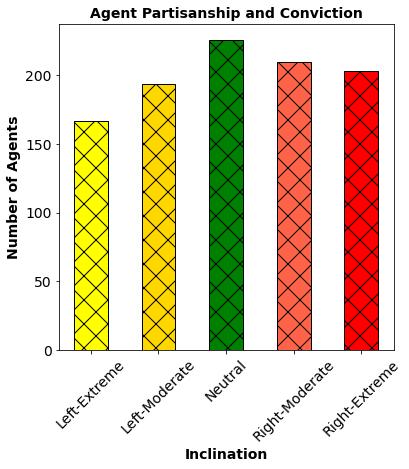

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import collections as matcoll
import seaborn as sns

# set width of bar
barWidth = 0.5
 
# Set position of bar on X axis
r1 = np.arange(5)
y = [torch.where(Agents[:,1]==1)[0].size()[0],torch.where(Agents[:,1]==2)[0].size()[0],torch.where(Agents[:,1]==3)[0].size()[0],torch.where(Agents[:,1]==4)[0].size()[0],torch.where(Agents[:,1]==5)[0].size()[0]]
fig, axs = plt.subplots(figsize=(6,6))
plt.bar(r1,y,color=['yellow','gold','green','tomato','red'],hatch='x',width=barWidth,edgecolor='black',label='Rigid')
plt.xlabel('Inclination', fontweight='bold',fontsize=14)
plt.ylabel('Number of Agents', fontweight='bold',fontsize=14)
plt.title('Agent Partisanship and Conviction', fontweight='bold',fontsize=14)
plt.xticks([r  for r in range(5)], ['Left-Extreme','Left-Moderate','Neutral', 'Right-Moderate','Right-Extreme'],rotation=45)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.rcParams['figure.facecolor'] = 'ivory'
# Create legend & Show graphic
plt.show()

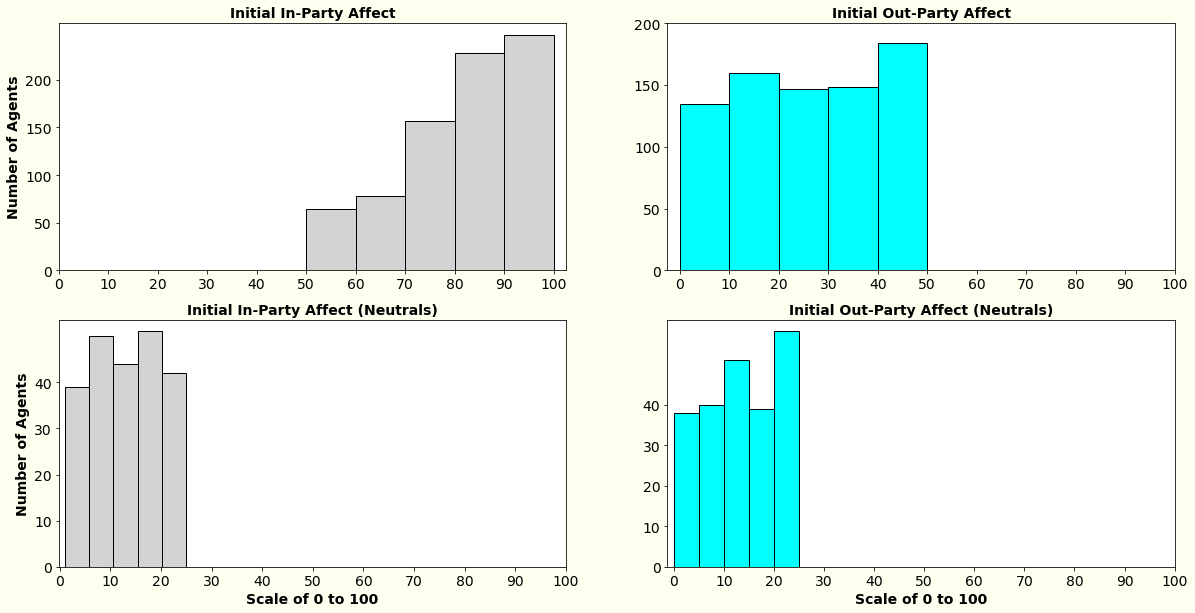

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=False,figsize=(20,10))
ax00 = axs[0,0]
ax01 = axs[0,1]
ax10 = axs[1,0]
ax11 = axs[1,1]
x = Agents[torch.where(torch.logical_and(Agents[:,2]>=50,Agents[:,0]!=2)==1)[0],2].cpu()
ax00.hist(x,bins=5,edgecolor='black',color='lightgray',)
ax00.set_ylabel('Number of Agents', fontweight='bold',fontsize=14)
ax00.set_title('Initial In-Party Affect', fontweight='bold',fontsize=14)
ax00.set_xticks(np.arange(0,110,step=10))
ax00.set_yticks(np.arange(0,250,step=50))
ax00.tick_params(axis='both', which='major', labelsize=14)

# ax00.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False, labelsize=14)
plt.rcParams['figure.facecolor'] = 'ivory'

x = Agents[torch.where(torch.logical_and(Agents[:,3]<=50,Agents[:,0]!=2)==1)[0],3].cpu()
ax01.hist(x,bins=5,edgecolor='black',color='cyan',)
ax01.set_title('Initial Out-Party Affect', fontweight='bold',fontsize=14)
ax01.set_xticks(np.arange(0,110,step=10))
ax01.set_yticks(np.arange(0,250,step=50))
ax01.tick_params(axis='both', which='major', labelsize=14)

# ax01.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False, labelsize=14)
plt.rcParams['figure.facecolor'] = 'ivory'

x = Agents[torch.where(torch.logical_and(Agents[:,2]<=50,Agents[:,0]==2)==1)[0],2].cpu()
ax10.hist(x,bins=5,edgecolor='black',color='lightgray',)
ax10.set_xlabel('Scale of 0 to 100', fontweight='bold',fontsize=14)
ax10.set_ylabel('Number of Agents', fontweight='bold',fontsize=14)
ax10.set_title('Initial In-Party Affect (Neutrals)', fontweight='bold',fontsize=14)
ax10.set_xticks(np.arange(0,110,step=10))
ax10.set_yticks(np.arange(0,50,step=10))
ax10.tick_params(axis='both', which='major', labelsize=14)
plt.rcParams['figure.facecolor'] = 'ivory'

x = Agents[torch.where(torch.logical_and(Agents[:,3]<=50,Agents[:,0]==2)==1)[0],3].cpu()
ax11.hist(x,bins=5,edgecolor='black',color='cyan',)
ax11.set_xlabel('Scale of 0 to 100', fontweight='bold',fontsize=14)
ax11.set_title('Initial Out-Party Affect (Neutrals)', fontweight='bold',fontsize=14)
ax11.set_xticks(np.arange(0,110,step=10))
ax11.set_yticks(np.arange(0,50,step=10))
ax11.tick_params(axis='both', which='major', labelsize=14)
plt.rcParams['figure.facecolor'] = 'ivory'

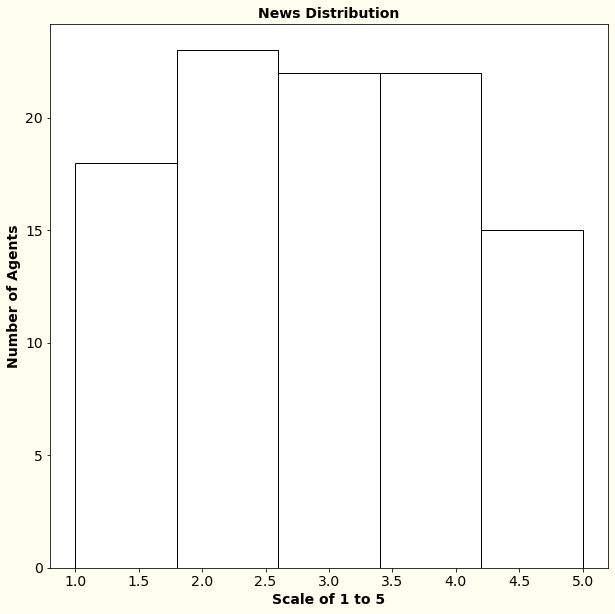

In [8]:
fig, axs = plt.subplots(figsize=(10,10))

x = News.cpu()
axs.hist(x,bins=5,edgecolor='black',color='white')
axs.set_xlabel('Scale of 1 to 5', fontweight='bold',fontsize=14)
axs.set_ylabel('Number of Agents', fontweight='bold',fontsize=14)
axs.set_title('News Distribution', fontweight='bold',fontsize=14)
axs.tick_params(axis='both', which='major', labelsize=14)
plt.rcParams['figure.facecolor'] = 'ivory'

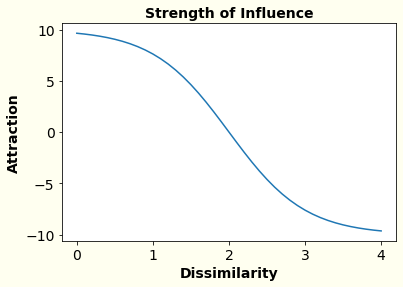

In [9]:
y = np.arange(0,4.1,step=0.1)
x = np.ones(41)
plt.plot(y,-10*(np.exp(2*(y-2)) - 1)/(np.exp(2*(y-2))+1))
# plt.plot(y,-10*((np.exp(y-2) - np.exp(-y+2))/(np.exp(y-2) + np.exp(-y+2))),color='black') 
# plt.plot(y,-9*((np.exp(y-2) - np.exp(-y+2))/(np.exp(y-2) + np.exp(-y+2))),color='red') 
# plt.plot(y,-8*((np.exp(y-2) - np.exp(-y+2))/(np.exp(y-2) + np.exp(-y+2))),color='green') 
plt.xlabel('Dissimilarity', fontweight='bold',fontsize=14)
plt.ylabel('Attraction', fontweight='bold',fontsize=14)
plt.title('Strength of Influence', fontweight='bold',fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
%reset -f 
import numpy as np
import torch
import random
import time
device = 'cuda'plt.rcParams['figure.facecolor'] = 'ivory'